<a href="https://colab.research.google.com/github/dwicahyomariyanto/Build-a-Chatbot-to-Analyze-PDF-Files-using-LLM/blob/main/Noise_Mitigation_for_H2_Molecule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 75.6 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [ ]:
# Define the molecule H2
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, 0, 0.0, 0.0, 1.4])

# Load the electronic Hamiltonian for H2
H, qubits = qml.qchem.molecular_hamiltonian(
    symbols, coordinates, charge=0, basis="sto-3g"
)

In [ ]:
# adding qubit auxiliary  (qubits + 1)
num_wires = 9 # 2 set qubits untuk virtual distillation + 1 auxiliary qubit

In [ ]:
# Describe noise model
fcond = qml.noise.wires_in(range(qubits))
noise = qml.noise.partial_wires(qml.PhaseDamping, 0.2)
noise_model = qml.NoiseModel({fcond: noise})

# Define ideal and noisy devices
dev_ideal = qml.device("default.mixed", wires=qubits) # 1 ini adalah qubit yang digunakan untuk kalkulasi Fubini metric tensor
dev_noisy = qml.add_noise(qml.device("default.mixed", wires=num_wires), noise_model=noise_model)

In [ ]:
def ansatz(params, wires):
    for i, w in enumerate(wires):
        qml.RZ(params[3 * i], wires=w)
        qml.RY(params[3 * i + 1], wires=w)
        qml.RZ(params[3 * i + 2], wires=w)
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.CNOT(wires=[wires[2], wires[0]])
    qml.CNOT(wires=[wires[3], wires[1]])

In [ ]:
# Initialize parameters
step_size = 0.5
iterations = 21
np.random.seed(0)
init_params = np.random.uniform(0, 2 * np.pi, size=12, requires_grad=True)

In [ ]:
# Define cost functions
@qml.qnode(dev_noisy, diff_method="parameter-shift")  # Specify diff_method
def cost_noisy(params):
    ansatz(params, wires=range(qubits))
    return qml.expval(H)

@qml.qnode(dev_ideal, diff_method="parameter-shift")  # Specify diff_method
def cost_ideal(params):
    ansatz(params, wires=range(qubits))
    return qml.expval(H)

In [ ]:
H2 = H.map_wires({0:4, 1:5, 2:6, 3:7})

@qml.qnode(dev_noisy, diff_method="parameter-shift")
def cost_mitigated(params):
    aux_wire = 2 * qubits # Auxiliary qubit untuk CSWAP

    # Siapkan dua salinan state (Copy 1 di [0,1,2,3], Copy 2 di [4,5,6,7])
    ansatz(params, wires=[0, 1, 2, 3])  # Copy 1
    ansatz(params, wires=[4, 5, 6, 7])  # Copy 2

    # Hadamard pada auxiliary qubit
    qml.Hadamard(wires=aux_wire)
    # Controlled-SWAP antara dua salinan
    for i in range(4):  # Karena ada 4 qubits dalam satu ansatz
        qml.CSWAP(wires=[aux_wire, i, i + 4])

    # Hadamard Test untuk Virtual Distillation
    qml.Hadamard(wires=aux_wire)

    # Menghitung ekspektasi nilai untuk semua qubit dengan Hamiltonian diperluas
    return qml.expval(H)


In [ ]:
print(f"cost_ideal: {cost_ideal(init_params)}")
print(f"cost_noisy: {cost_noisy(init_params)}")
print(f"cost_mitigated: {cost_mitigated(init_params)}")

cost_ideal: -0.5195682910702177
cost_noisy: -0.5098149027908931
cost_mitigated: -0.5146915969305881


In [ ]:
opt_ideal = qml.QNGOptimizer(step_size, approx="block-diag", lam=0.001)

# Optimization loop for noisy case
print("Optimizing (Ideal Device)...")
params_mitigated = init_params.copy()
energies_ideal = []
for n in range(iterations):
    params_mitigated, energy = opt_ideal.step_and_cost(cost_ideal, params_mitigated)
    energies_ideal.append(energy)
    print(f"Ideal Iteration {n}: Energy = {energy:.8f} Ha")

Optimizing (Ideal Device)...
Ideal Iteration 0: Energy = -0.51956829 Ha
Ideal Iteration 1: Energy = -0.93479426 Ha
Ideal Iteration 2: Energy = -1.10541465 Ha
Ideal Iteration 3: Energy = -1.13249884 Ha
Ideal Iteration 4: Energy = -1.13645208 Ha
Ideal Iteration 5: Energy = -1.13710419 Ha
Ideal Iteration 6: Energy = -1.13723281 Ha
Ideal Iteration 7: Energy = -1.13726301 Ha
Ideal Iteration 8: Energy = -1.13727160 Ha
Ideal Iteration 9: Energy = -1.13727440 Ha
Ideal Iteration 10: Energy = -1.13727538 Ha
Ideal Iteration 11: Energy = -1.13727573 Ha
Ideal Iteration 12: Energy = -1.13727587 Ha
Ideal Iteration 13: Energy = -1.13727591 Ha
Ideal Iteration 14: Energy = -1.13727593 Ha
Ideal Iteration 15: Energy = -1.13727594 Ha
Ideal Iteration 16: Energy = -1.13727594 Ha
Ideal Iteration 17: Energy = -1.13727594 Ha
Ideal Iteration 18: Energy = -1.13727594 Ha
Ideal Iteration 19: Energy = -1.13727594 Ha
Ideal Iteration 20: Energy = -1.13727594 Ha


In [ ]:
opt_noisy = qml.QNGOptimizer(step_size, approx="block-diag", lam=0.001)

# Optimization loop for noisy case
print("Optimizing (Noisy Device)...")
params_mitigated = init_params.copy()
energies_noisy = []
for n in range(iterations):
    params_mitigated, energy = opt_noisy.step_and_cost(cost_noisy, params_mitigated)
    energies_noisy.append(energy)
    print(f"Noisy Iteration {n }: Energy = {energy:.8f} Ha")

Optimizing (Noisy Device)...
Noisy Iteration 0: Energy = -0.50981490 Ha
Noisy Iteration 1: Energy = -0.89796939 Ha
Noisy Iteration 2: Energy = -1.08232063 Ha
Noisy Iteration 3: Energy = -1.11442324 Ha
Noisy Iteration 4: Energy = -1.11920921 Ha
Noisy Iteration 5: Energy = -1.12001373 Ha
Noisy Iteration 6: Energy = -1.12016285 Ha
Noisy Iteration 7: Energy = -1.12019261 Ha
Noisy Iteration 8: Energy = -1.12019910 Ha
Noisy Iteration 9: Energy = -1.12020066 Ha
Noisy Iteration 10: Energy = -1.12020108 Ha
Noisy Iteration 11: Energy = -1.12020120 Ha
Noisy Iteration 12: Energy = -1.12020124 Ha
Noisy Iteration 13: Energy = -1.12020125 Ha
Noisy Iteration 14: Energy = -1.12020125 Ha
Noisy Iteration 15: Energy = -1.12020125 Ha
Noisy Iteration 16: Energy = -1.12020125 Ha
Noisy Iteration 17: Energy = -1.12020125 Ha
Noisy Iteration 18: Energy = -1.12020125 Ha
Noisy Iteration 19: Energy = -1.12020125 Ha
Noisy Iteration 20: Energy = -1.12020125 Ha


In [ ]:
opt_mitigated = qml.QNGOptimizer(step_size, approx="block-diag", lam=0.001)

# Optimization loop for noisy case
print("Optimizing (Mitigated Device)...")
params_mitigated = init_params.copy()
energies_mitigated = []
for n in range(iterations):
    params_mitigated, energy = opt_mitigated.step_and_cost(cost_mitigated, params_mitigated)
    energies_mitigated.append(energy)
    print(f"Mitigated Iteration {n + 1}: Energy = {energy:.8f} Ha")

Optimizing (Mitigated Device)...
Mitigated Iteration 1: Energy = -0.51469160 Ha
Mitigated Iteration 2: Energy = -0.72874508 Ha
Mitigated Iteration 3: Energy = -0.91627566 Ha
Mitigated Iteration 4: Energy = -1.02671591 Ha
Mitigated Iteration 5: Energy = -1.08030732 Ha
Mitigated Iteration 6: Energy = -1.10534664 Ha
Mitigated Iteration 7: Energy = -1.11691400 Ha
Mitigated Iteration 8: Energy = -1.12225775 Ha
Mitigated Iteration 9: Energy = -1.12474633 Ha
Mitigated Iteration 10: Energy = -1.12591765 Ha
Mitigated Iteration 11: Energy = -1.12647471 Ha
Mitigated Iteration 12: Energy = -1.12674201 Ha
Mitigated Iteration 13: Energy = -1.12687122 Ha
Mitigated Iteration 14: Energy = -1.12693404 Ha
Mitigated Iteration 15: Energy = -1.12696472 Ha
Mitigated Iteration 16: Energy = -1.12697975 Ha
Mitigated Iteration 17: Energy = -1.12698714 Ha
Mitigated Iteration 18: Energy = -1.12699078 Ha
Mitigated Iteration 19: Energy = -1.12699257 Ha
Mitigated Iteration 20: Energy = -1.12699345 Ha
Mitigated Iterat


Plot Energy

In [ ]:
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle

# Data from user (pastikan energi-energi berikut sudah didefinisikan sebelumnya)
# Menggunakan panjang array yang paling panjang untuk sumbu X
iterations = np.arange(len(energies_ideal))

# Menggunakan seaborn untuk mengatur gaya latar belakang
sns.set(style="ticks")

# Membuat figure dan axis dengan ukuran lebih besar
fig, ax1 = plt.subplots(figsize=(9, 7))  # Ukuran figure lebih besar agar bisa menampung gambar

# Plot Energy vs Iteration Steps
# Convert lists to NumPy arrays before plotting
sns.lineplot(x=iterations, y=np.array(energies_ideal), label="Ideal", color='blue')
sns.lineplot(x=iterations, y=np.array(energies_noisy), label="Noisy", color='purple')
sns.lineplot(x=iterations, y=np.array(energies_mitigated), label="Virtual Distilation", color='green')

# 4) Label, reference line, legend, grid
ax1.set_xlabel("Step", fontsize=18)  # Membuat xlabel lebih besar dan bold
ax1.set_ylabel("Energy (Ha)", fontsize=18)  # Membuat ylabel lebih besar dan bold
# 5) Mengubah ukuran angka pada sumbu X dan Y
ax1.tick_params(axis='x', labelsize=16)  # Memperbesar angka pada sumbu X
ax1.tick_params(axis='y', labelsize=16)  # Memperbesar angka pada sumbu Y

# Define exact value
exact_value = -1.136 # Replace with your actual reference energy

# Menambahkan garis horizontal putus-putus pada y = -0.82
ax1.axhline(y=exact_value, color='gray', linestyle='--', label="Reference Energy")

# Menambahkan legend dengan kotak yang lebih jelas
ax1.legend(frameon=True, edgecolor='black', facecolor='white', fontsize=12)

# Mengatur grid dengan garis putus-putus dan warna grid yang lebih terang
ax1.grid(True, linestyle='--', color='gray', alpha=0.5)  # garis putus-putus dan transparansi

# Menampilkan hanya angka genap pada sumbu X
ax1.set_xticks(np.arange(0, len(iterations), 2))  # Set sumbu X untuk angka genap saja

# Menampilkan plot
plt.tight_layout()
plt.show()

Plot triangular

In [ ]:
# Metric tensor for Quantum Natural Gradient
mt_fn = qml.metric_tensor(cost_ideal, approx='block-diag')

diag_history = []  # untuk menyimpan elemen diagonal tiap iterasi
params = init_params.copy()  # copy supaya tidak overwrite variabel awal

for n in range(10):
    params = opt_ideal.step(cost_ideal, params)  # update parameter
    metric_tensor = mt_fn(params)  # hitung metric tensor

    # Ambil hanya elemen diagonal
    diag_elements = np.diag(metric_tensor)

    # Terapkan threshold: nilai < 0.001 menjadi 0
    diag_elements = np.where(np.abs(diag_elements) < 0.0001, 0, diag_elements)

    diag_history.append(diag_elements)

    # Print hasil diagonal yang sudah difilter
    print(f"\nIteration: {n}")
    print("Diagonal elements of metric tensor:")
    print(diag_elements)

# Jika ingin hasilnya dalam bentuk numpy array (5 iterasi x dimensi param)
diag_history = np.array(diag_history)



Iteration: 0
Diagonal elements of metric tensor:
[0.         0.25       0.13464588 0.         0.25       0.02158705
 0.         0.25       0.01817869 0.         0.25       0.09654013]

Iteration: 1
Diagonal elements of metric tensor:
[0.         0.25       0.03344945 0.         0.25       0.00354018
 0.         0.25       0.00534646 0.         0.25       0.00771164]

Iteration: 2
Diagonal elements of metric tensor:
[0.         0.25       0.00594344 0.         0.25       0.0005307
 0.         0.25       0.016598   0.         0.25       0.00031434]

Iteration: 3
Diagonal elements of metric tensor:
[0.         0.25       0.00091607 0.         0.25       0.
 0.         0.25       0.01018357 0.         0.25       0.        ]

Iteration: 4
Diagonal elements of metric tensor:
[0.00000000e+00 2.50000000e-01 1.43083817e-04 0.00000000e+00
 2.50000000e-01 0.00000000e+00 0.00000000e+00 2.50000000e-01
 1.40734879e-02 0.00000000e+00 2.50000000e-01 0.00000000e+00]

Iteration: 5
Diagonal elements of 

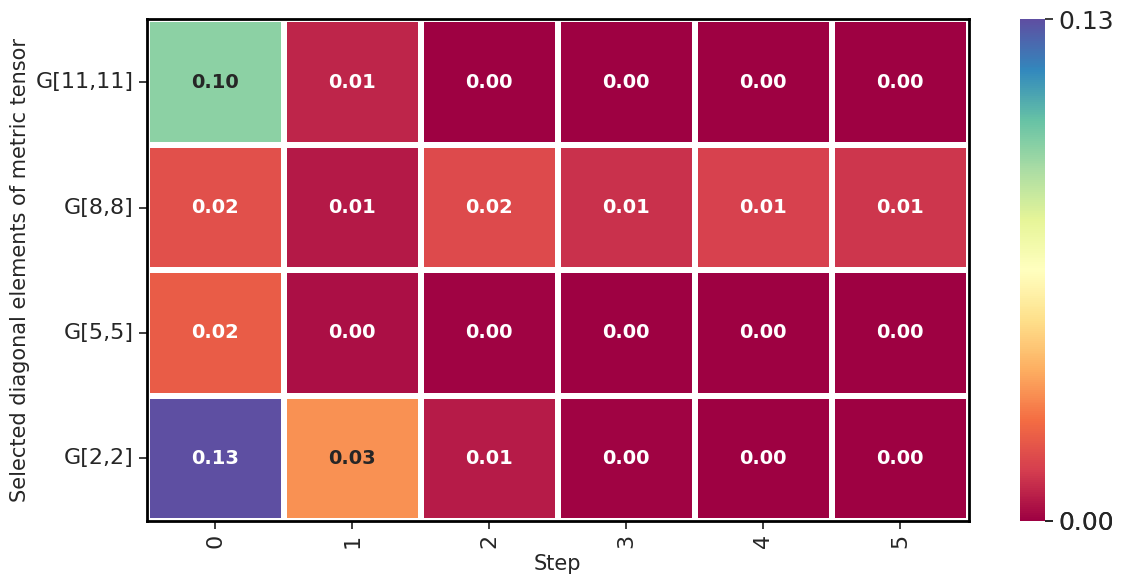

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Misal sebelumnya sudah dihitung:
# diag_history = np.array(diag_history)  # bentuk (n_iter, n_diag)

data = diag_history
n_iter = 6  # Batasi menjadi 15 iterasi
data = data[:n_iter]  # Ambil hanya 15 iterasi pertama

# Pilih hanya 4 elemen diagonal tertentu
selected_indices = [2, 5, 8, 11]
data = data[:, selected_indices]

# Set the style for seaborn
sns.set(style="ticks")

# Tentukan nilai minimum dan maksimum dari data untuk memastikan 0 di tengah
vmin = 0.00
vmax = 0.13

plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    data.T,   # transpose: baris = elemen terpilih, kolom = iterasi
    cmap='Spectral',
    cbar=True,
    cbar_kws={"shrink": 1, 'ticks': [vmin, 0, vmax]},
    linewidths=3,
    linecolor='white',
    annot=True,
    fmt='.2f',
    annot_kws={"size": 14, "weight": 'bold'},
    vmin=vmin,
    vmax=vmax
)

# Sumbu tegas
for side in ['top', 'right', 'left', 'bottom']:
    ax.spines[side].set_visible(True)
    ax.spines[side].set_linewidth(2)
    ax.spines[side].set_color('black')

# X-axis ticks: di tengah setiap kolom
ax.set_xticks(np.arange(n_iter) + 0.5)
ax.set_xticklabels(np.arange(n_iter), rotation=90, fontsize=16)

# Y-axis ticks & labels: hanya 4 elemen yang dipilih
element_labels = [f"G[{i},{i}]" for i in selected_indices]
ax.set_yticks(np.arange(len(selected_indices)) + 0.5)
ax.set_yticklabels(element_labels, rotation=0, fontsize=16)

# Label sumbu
ax.set_xlabel('Step', fontsize=15)
ax.set_ylabel('Selected diagonal elements of metric tensor', fontsize=15)

# Balik agar G[2,2] ada di atas
ax.invert_yaxis()

# Atur colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.show()


In [ ]:
# Metric tensor for Quantum Natural Gradient
mt_fn = qml.metric_tensor(cost_noisy, approx='block-diag')

diag_history = []  # untuk menyimpan elemen diagonal tiap iterasi
params = init_params.copy()  # copy supaya tidak overwrite variabel awal

for n in range(10):
    params = opt_ideal.step(cost_noisy, params)  # update parameter
    metric_tensor = mt_fn(params)  # hitung metric tensor

    # Ambil hanya elemen diagonal
    diag_elements = np.diag(metric_tensor)

    # Terapkan threshold: nilai < 0.001 menjadi 0
    diag_elements = np.where(np.abs(diag_elements) < 0.0001, 0, diag_elements)

    diag_history.append(diag_elements)

    # Print hasil diagonal yang sudah difilter
    print(f"\nIteration: {n}")
    print("Diagonal elements of metric tensor:")
    print(diag_elements)

# Jika ingin hasilnya dalam bentuk numpy array (5 iterasi x dimensi param)
diag_history = np.array(diag_history)



Iteration: 0
Diagonal elements of metric tensor:
[0.         0.25       0.13852509 0.         0.25       0.022259
 0.         0.25       0.01518384 0.         0.25       0.11440207]

Iteration: 1
Diagonal elements of metric tensor:
[0.00000000e+00 2.50000000e-01 3.78679523e-02 0.00000000e+00
 2.50000000e-01 4.33633428e-03 0.00000000e+00 2.50000000e-01
 1.89772841e-04 0.00000000e+00 2.50000000e-01 1.36384149e-02]

Iteration: 2
Diagonal elements of metric tensor:
[0.         0.25       0.00747113 0.         0.25       0.00072393
 0.         0.25       0.00368473 0.         0.25       0.00082025]

Iteration: 3
Diagonal elements of metric tensor:
[0.00000000e+00 2.50000000e-01 1.32955019e-03 0.00000000e+00
 2.50000000e-01 1.23887344e-04 0.00000000e+00 2.50000000e-01
 1.48334497e-03 0.00000000e+00 2.50000000e-01 0.00000000e+00]

Iteration: 4
Diagonal elements of metric tensor:
[0.00000000e+00 2.50000000e-01 2.34709717e-04 0.00000000e+00
 2.50000000e-01 0.00000000e+00 0.00000000e+00 2.50000

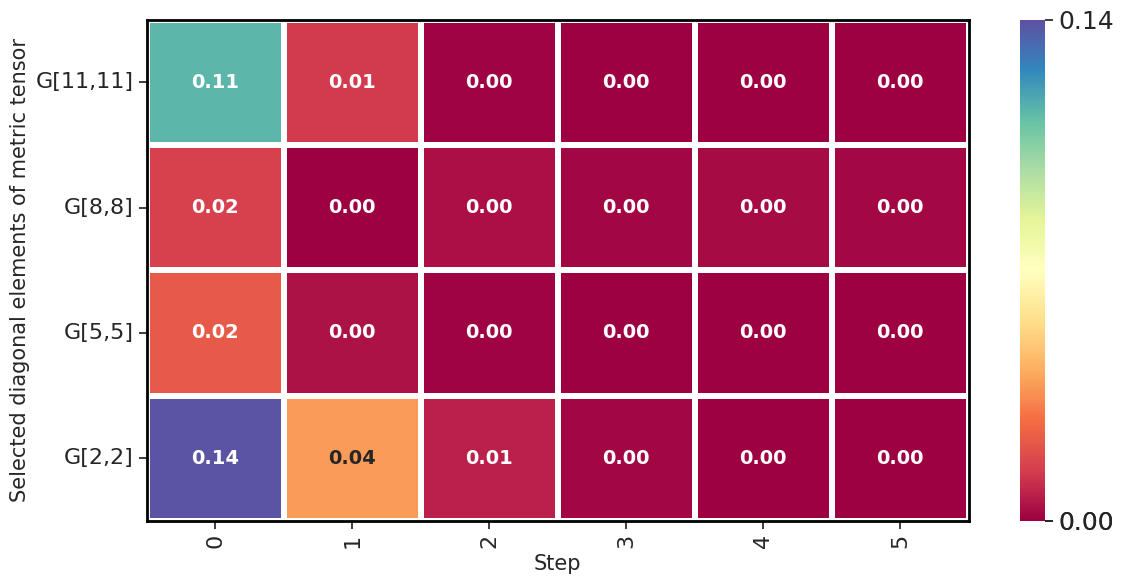

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Misal sebelumnya sudah dihitung:
# diag_history = np.array(diag_history)  # bentuk (n_iter, n_diag)

data = diag_history
n_iter = 6  # Batasi menjadi 15 iterasi
data = data[:n_iter]  # Ambil hanya 15 iterasi pertama

# Pilih hanya 4 elemen diagonal tertentu
selected_indices = [2, 5, 8, 11]
data = data[:, selected_indices]

# Set the style for seaborn
sns.set(style="ticks")

# Tentukan nilai minimum dan maksimum dari data untuk memastikan 0 di tengah
vmin = 0.00
vmax = 0.14

plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    data.T,   # transpose: baris = elemen terpilih, kolom = iterasi
    cmap='Spectral',
    cbar=True,
    cbar_kws={"shrink": 1, 'ticks': [vmin, 0, vmax]},
    linewidths=3,
    linecolor='white',
    annot=True,
    fmt='.2f',
    annot_kws={"size": 14, "weight": 'bold'},
    vmin=vmin,
    vmax=vmax
)

# Sumbu tegas
for side in ['top', 'right', 'left', 'bottom']:
    ax.spines[side].set_visible(True)
    ax.spines[side].set_linewidth(2)
    ax.spines[side].set_color('black')

# X-axis ticks: di tengah setiap kolom
ax.set_xticks(np.arange(n_iter) + 0.5)
ax.set_xticklabels(np.arange(n_iter), rotation=90, fontsize=16)

# Y-axis ticks & labels: hanya 4 elemen yang dipilih
element_labels = [f"G[{i},{i}]" for i in selected_indices]
ax.set_yticks(np.arange(len(selected_indices)) + 0.5)
ax.set_yticklabels(element_labels, rotation=0, fontsize=16)

# Label sumbu
ax.set_xlabel('Step', fontsize=15)
ax.set_ylabel('Selected diagonal elements of metric tensor', fontsize=15)

# Balik agar G[2,2] ada di atas
ax.invert_yaxis()

# Atur colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.show()


In [ ]:
# Metric tensor for Quantum Natural Gradient
mt_fn = qml.metric_tensor(cost_mitigated, approx='block-diag')

diag_history = []  # untuk menyimpan elemen diagonal tiap iterasi
params = init_params.copy()  # copy supaya tidak overwrite variabel awal

for n in range(6):
    params = opt_ideal.step(cost_mitigated, params)  # update parameter
    metric_tensor = mt_fn(params)  # hitung metric tensor

    # Ambil hanya elemen diagonal
    diag_elements = np.diag(metric_tensor)

    # Terapkan threshold: nilai < 0.001 menjadi 0
    diag_elements = np.where(np.abs(diag_elements) < 0.0001, 0, diag_elements)

    diag_history.append(diag_elements)

    # Print hasil diagonal yang sudah difilter
    print(f"\nIteration: {n}")
    print("Diagonal elements of metric tensor:")
    print(diag_elements)

# Jika ingin hasilnya dalam bentuk numpy array (5 iterasi x dimensi param)
diag_history = np.array(diag_history)



Iteration: 0
Diagonal elements of metric tensor:
[0.         0.5        0.39363709 0.         0.5        0.07226497
 0.         0.5        0.10259291 0.         0.5        0.35725013]

Iteration: 1
Diagonal elements of metric tensor:
[0.         0.5        0.27321306 0.         0.5        0.04122292
 0.         0.5        0.0390074  0.         0.5        0.20776485]

Iteration: 2
Diagonal elements of metric tensor:
[0.         0.5        0.16385364 0.         0.5        0.02091634
 0.         0.5        0.01627502 0.         0.5        0.09500048]

Iteration: 3
Diagonal elements of metric tensor:
[0.         0.5        0.08999809 0.         0.5        0.01021753
 0.         0.5        0.011647   0.         0.5        0.0381455 ]

Iteration: 4
Diagonal elements of metric tensor:
[0.         0.5        0.04708266 0.         0.5        0.0049787
 0.         0.5        0.01156717 0.         0.5        0.01445878]

Iteration: 5
Diagonal elements of metric tensor:
[0.         0.5        0.0

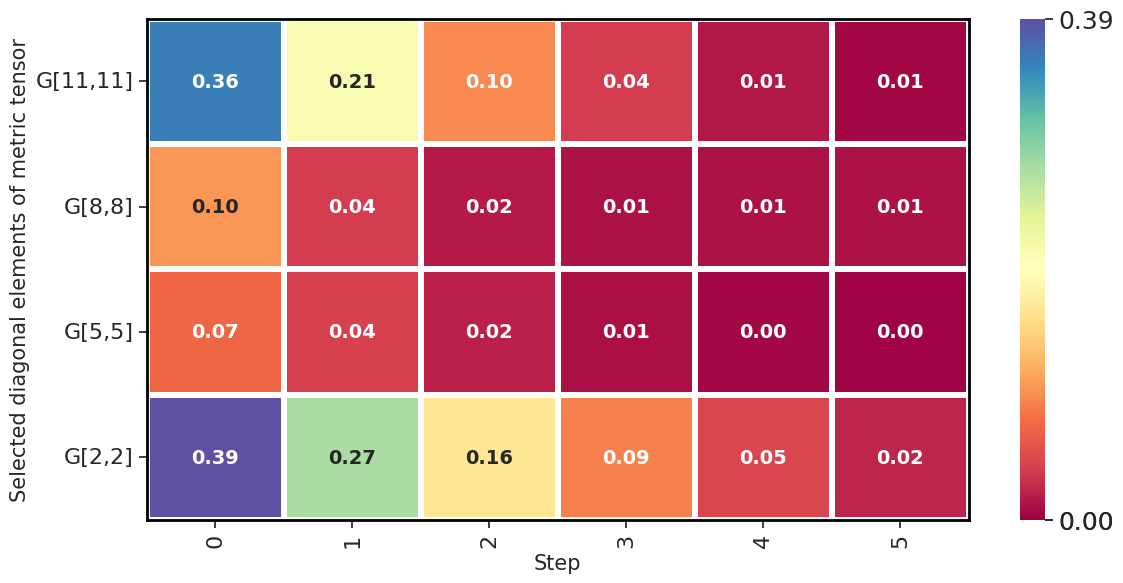

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Misal sebelumnya sudah dihitung:
# diag_history = np.array(diag_history)  # bentuk (n_iter, n_diag)

data = diag_history
n_iter = 6  # Batasi menjadi 15 iterasi
data = data[:n_iter]  # Ambil hanya 15 iterasi pertama

# Pilih hanya 4 elemen diagonal tertentu
selected_indices = [2, 5, 8, 11]
data = data[:, selected_indices]

# Set the style for seaborn
sns.set(style="ticks")

# Tentukan nilai minimum dan maksimum dari data untuk memastikan 0 di tengah
vmin = 0.00
vmax = 0.39

plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    data.T,   # transpose: baris = elemen terpilih, kolom = iterasi
    cmap='Spectral',
    cbar=True,
    cbar_kws={"shrink": 1, 'ticks': [vmin, 0, vmax]},
    linewidths=3,
    linecolor='white',
    annot=True,
    fmt='.2f',
    annot_kws={"size": 14, "weight": 'bold'},
    vmin=vmin,
    vmax=vmax
)

# Sumbu tegas
for side in ['top', 'right', 'left', 'bottom']:
    ax.spines[side].set_visible(True)
    ax.spines[side].set_linewidth(2)
    ax.spines[side].set_color('black')

# X-axis ticks: di tengah setiap kolom
ax.set_xticks(np.arange(n_iter) + 0.5)
ax.set_xticklabels(np.arange(n_iter), rotation=90, fontsize=16)

# Y-axis ticks & labels: hanya 4 elemen yang dipilih
element_labels = [f"G[{i},{i}]" for i in selected_indices]
ax.set_yticks(np.arange(len(selected_indices)) + 0.5)
ax.set_yticklabels(element_labels, rotation=0, fontsize=16)

# Label sumbu
ax.set_xlabel('Step', fontsize=15)
ax.set_ylabel('Selected diagonal elements of metric tensor', fontsize=15)

# Balik agar G[2,2] ada di atas
ax.invert_yaxis()

# Atur colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.show()
